In [1]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from joblib import load as jload
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tuning_parameters as tp
import eye_fcn_par as efp

2021-10-17 17:21:46.745497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 17:21:46.745520: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
PATH2PROJECT = ""
subject_num = tp.NUMBER
R_TRAIN = 0.85
N_EPOCHS = 50
PATIENCE = 10
TRAINABLE_LAYERS = 1

In [3]:
in_blink_out_fol = PATH2PROJECT + f"subjects/{subject_num}/in_blink_out/"

with open(in_blink_out_fol + "x1.pickle", "rb") as f:
    x1_load = pickle.load(f)
with open(in_blink_out_fol + "x2.pickle", "rb") as f:
    x2_load = pickle.load(f)
with open(in_blink_out_fol + "y.pickle", "rb") as f:
    y = pickle.load(f)

n_smp, frame_height, frame_width = x1_load.shape[:-1]

print(n_smp, frame_height, frame_width)

150 48 44


In [4]:
x2_chs_inp = x2_load[:, efp.CHOSEN_INPUTS]

2


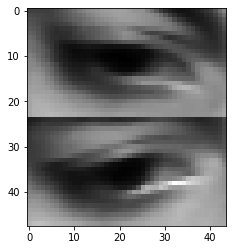

In [5]:
SAMPLE_NUMBER = 110
print(y[SAMPLE_NUMBER])
plt.imshow(x1_load[SAMPLE_NUMBER].reshape((frame_height, frame_width)), cmap="gray")
plt.show()

In [6]:
scalers = jload(PATH2PROJECT + tp.IN_BLINK_OUT_SCALERS_DIR)
x1_scaler, x2_scaler = scalers

x1 = x1_load / x1_scaler
x2 = x2_scaler.transform(x2_chs_inp)

/home/mostafa/Projects/EyeTracker/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [7]:
x1_shf, x2_shf, y_shf = shuffle(x1, x2, y)

n_train = int(R_TRAIN * n_smp)
n_test = n_smp - n_train
x1_train, x2_train = x1_shf[:n_train], x2_shf[:n_train]
x1_test, x2_test = x1_shf[n_train:], x2_shf[n_train:]
y_train = y_shf[:n_train]
y_test = y_shf[n_train:]

print(x1_train.shape, x1_test.shape, x2_train.shape, x2_test.shape,
      y_train.shape, y_test.shape)

(127, 48, 44, 1) (23, 48, 44, 1) (127, 7) (23, 7) (127,) (23,)


In [8]:
y_train_ctg = to_categorical(y_train)
y_test_ctg = to_categorical(y_test)

In [9]:
x_train_list = [x1_train, x2_train]
x_test_list = [x1_test, x2_test]

In [10]:
cb = EarlyStopping(patience=PATIENCE, verbose=1, restore_best_weights=True)

In [11]:
public_model_dir = PATH2PROJECT + tp.IN_BLINK_OUT_PUBLIC_MODEL_DIR

model = load_model(public_model_dir)
print(model.summary())

2021-10-17 17:21:48.743199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-17 17:21:48.743727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-17 17:21:48.743810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-17 17:21:48.743890: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-17 17:21:48.743968: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 44, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 48, 44, 16)   416         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 24, 22, 16)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 24, 22, 32)   12832       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [12]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True)

In [13]:
for layer in model.layers[:-TRAINABLE_LAYERS]:
    layer.trainable = False
for layer in model.layers:
    print(layer, layer.trainable)

print(model.summary())

<keras.engine.input_layer.InputLayer object at 0x7f4a6daa3ac0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a6da87e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a6c1a4730> False
<keras.layers.convolutional.Conv2D object at 0x7f4a6c1a4a30> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a6c1702b0> False
<keras.layers.convolutional.Conv2D object at 0x7f4a6c1705b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4a6c170df0> False
<keras.layers.core.Flatten object at 0x7f4a6c177160> False
<keras.layers.core.Dense object at 0x7f4a6c177370> False
<keras.engine.input_layer.InputLayer object at 0x7f4a6c177a60> False
<keras.layers.merge.Concatenate object at 0x7f4a6c177e80> False
<keras.layers.core.Dense object at 0x7f4a6c17e040> False
<keras.layers.core.Dense object at 0x7f4a6c17e550> False
<keras.layers.core.Dense object at 0x7f4a6c17e6d0> False
<keras.layers.core.Dense object at 0x7f4a6c189190> False
<keras.layers.core.Dense object at 0x7f4a6c1892b0> T

In [14]:
results = model.fit(x_train_list,
                    y_train_ctg,
                    validation_data=(x_test_list, y_test_ctg),
                    epochs=N_EPOCHS,
                    callbacks=cb)

Epoch 1/50


2021-10-17 17:21:49.543017: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4/4 [==============================] - 1s 98ms/step - loss: 3.5697 - acc: 0.7953 - val_loss: 1.8454 - val_acc: 0.6957
Epoch 2/50
4/4 [==============================] - 0s 48ms/step - loss: 1.2402 - acc: 0.8189 - val_loss: 1.2261 - val_acc: 0.6957
Epoch 3/50
4/4 [==============================] - 0s 49ms/step - loss: 0.6956 - acc: 0.8504 - val_loss: 0.8622 - val_acc: 0.8261
Epoch 4/50
4/4 [==============================] - 0s 47ms/step - loss: 0.4814 - acc: 0.8976 - val_loss: 0.6013 - val_acc: 0.8261
Epoch 5/50
4/4 [==============================] - 0s 44ms/step - loss: 0.2919 - acc: 0.9291 - val_loss: 0.3834 - val_acc: 0.7391
Epoch 6/50
4/4 [==============================] - 0s 44ms/step - loss: 0.2488 - acc: 0.9370 - val_loss: 0.3546 - val_acc: 0.7826
Epoch 7/50
4/4 [==============================] - 0s 43ms/step - loss: 0.2178 - acc: 0.9291 - val_loss: 0.3609 - val_acc: 0.8261
Epoch 8/50
4/4 [==============================] - 0s 47ms/step - loss: 0.1971 - acc: 0.9449 - val_loss: 0.35

In [15]:
yhat_train = model.predict(x_train_list).argmax(1)
yhat_test = model.predict(x_test_list).argmax(1)

Test
0
0


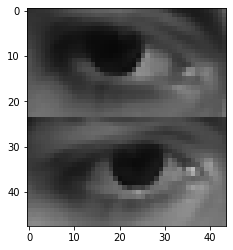

In [16]:
SAMPLE_NUMBER = 3
print("Test")
print(y_test[SAMPLE_NUMBER])
print(yhat_test[SAMPLE_NUMBER])
plt.imshow(
    (x1_test[SAMPLE_NUMBER].reshape((frame_height, frame_width)) * 255)
    .astype(np.uint8),
    cmap="gray",
    vmin=0,
    vmax=255
    )
plt.show()

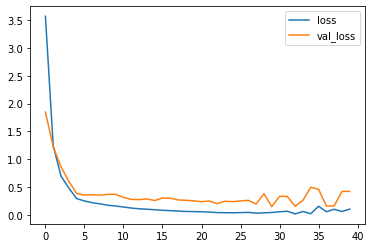

In [17]:
loss = results.history["loss"]
val_loss = results.history["val_loss"]
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

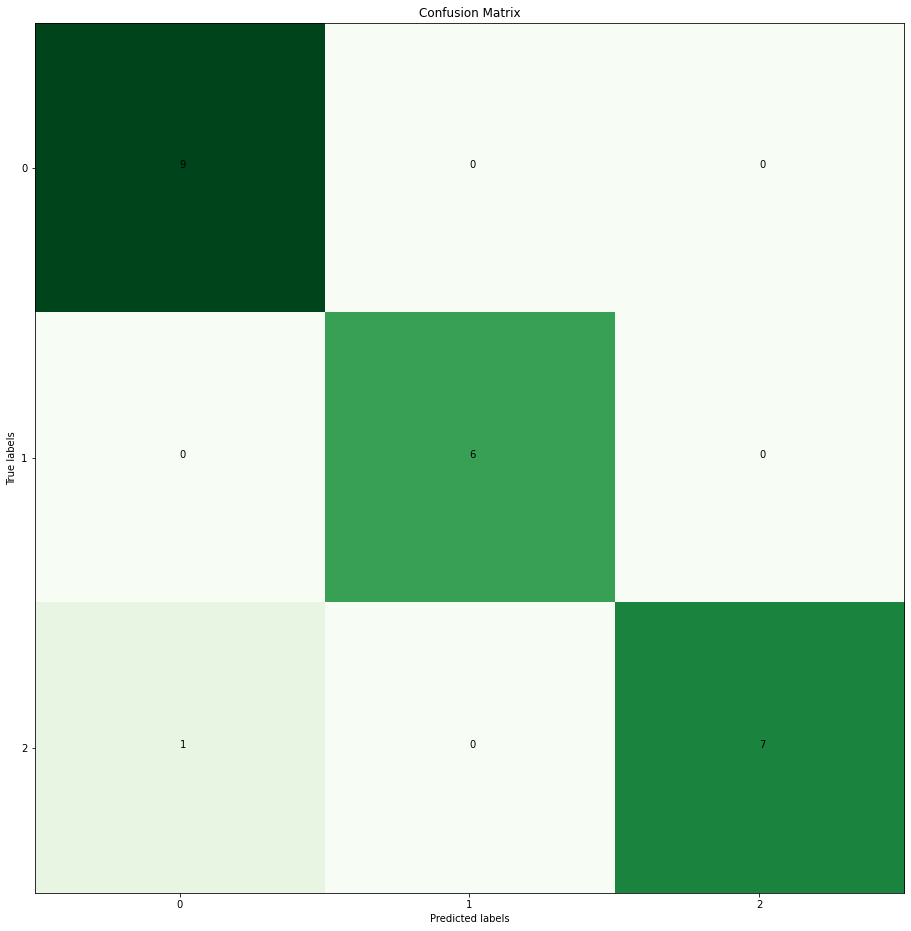

In [18]:
n_class = y_train_ctg.shape[1]
cm_test = confusion_matrix(y_test, yhat_test)
plt.figure(figsize=(16,16))
plt.imshow(cm_test, cmap=plt.cm.Greens)
class_arr = np.arange(n_class)
plt.xticks(class_arr)
plt.yticks(class_arr)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

for i in range(n_class):
  for j in range(n_class):
    plt.text(i, j, cm_test[j][i])

In [19]:
model.save(PATH2PROJECT + tp.IN_BLINK_OUT_SUBJECT_MODEL_DIR)

2021-10-17 17:21:58.219901: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: subjects/1/in_blink_out/model/assets
